<a href="https://colab.research.google.com/github/lauren-kirsh/Data-Science-Portfolio/blob/main/HW1_DS_UA_202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Responsible Data Science Spring 2021: Homework 1


This notebook contains sample code; other methods at arriving at the correct answer were also accepted.

In [ ]:
!pip install aif360==0.3.0 
!pip install BlackBoxAuditing
!pip install tensorflow==1.12.0
import matplotlib.pyplot as plt 

import random
random.seed(6)

import sys
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.algorithms.inprocessing import AdversarialDebiasing
from aif360.algorithms.inprocessing.meta_fair_classifier import MetaFairClassifier
import BlackBoxAuditing
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import CompasDataset, AdultDataset, StandardDataset, BankDataset, GermanDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.postprocessing import EqOddsPostprocessing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult


from aif360.algorithms.inprocessing import GerryFairClassifier
from aif360.algorithms.inprocessing import PrejudiceRemover

from sklearn.preprocessing import MinMaxScaler
from aif360.metrics import BinaryLabelDatasetMetric

from aif360.algorithms.postprocessing.reject_option_classification import RejectOptionClassification
import seaborn as sns

%matplotlib inline

ERROR: Could not find a version that satisfies the requirement tensorflow==1.12.0 (from versions: 1.13.0rc1, 1.13.0rc2, 1.13.1, 1.13.2, 1.14.0rc0, 1.14.0rc1, 1.14.0, 1.15.0rc0, 1.15.0rc1, 1.15.0rc2, 1.15.0rc3, 1.15.0, 1.15.2, 1.15.3, 1.15.4, 1.15.5, 2.0.0a0, 2.0.0b0, 2.0.0b1, 2.0.0rc0, 2.0.0rc1, 2.0.0rc2, 2.0.0, 2.0.1, 2.0.2, 2.0.3, 2.0.4, 2.1.0rc0, 2.1.0rc1, 2.1.0rc2, 2.1.0, 2.1.1, 2.1.2, 2.1.3, 2.2.0rc0, 2.2.0rc1, 2.2.0rc2, 2.2.0rc3, 2.2.0rc4, 2.2.0, 2.2.1, 2.2.2, 2.3.0rc0, 2.3.0rc1, 2.3.0rc2, 2.3.0, 2.3.1, 2.3.2, 2.4.0rc0, 2.4.0rc1, 2.4.0rc2, 2.4.0rc3, 2.4.0rc4, 2.4.0, 2.4.1)
ERROR: No matching distribution found for tensorflow==1.12.0


pip install 'aif360[LFR]'


# Problem 2
### **Load and split data into train, validation and test sets** 

### Read in the data

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
!wget	https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names

--2021-03-08 22:13:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3974305 (3.8M) [application/x-httpd-php]
Saving to: ‘adult.data.2’

adult.data.2        100%[===================>]   3.79M  3.25MB/s    in 1.2s    

2021-03-08 22:13:12 (3.25 MB/s) - ‘adult.data.2’ saved [3974305/3974305]

--2021-03-08 22:13:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2003153 (1.9M) [application/x-httpd-php]
Saving to: ‘adult.test.2’

adult.test.2        100%[===================>]   1.91M  2.06MB/s    in 0.9s    

In [ ]:
!cp adult.data /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.test /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/
!cp adult.names /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult/

### Define privileged and unprivileged groups; select a protected attribute of your choice

In [ ]:

dataset_orig = AdultDataset(protected_attribute_names=['sex'],
                            privileged_classes=[['Male']],
                            features_to_drop=['race', 'age'])

privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig.convert_to_dataframe()

(         fnlwgt  education-num  ...  native-country=Yugoslavia  income-per-year
 0      226802.0            7.0  ...                        0.0              0.0
 1       89814.0            9.0  ...                        0.0              0.0
 2      336951.0           12.0  ...                        0.0              1.0
 3      160323.0           10.0  ...                        0.0              1.0
 5      198693.0            6.0  ...                        0.0              0.0
 ...         ...            ...  ...                        ...              ...
 48837  257302.0           12.0  ...                        0.0              0.0
 48838  154374.0            9.0  ...                        0.0              1.0
 48839  151910.0            9.0  ...                        0.0              0.0
 48840  201490.0            9.0  ...                        0.0              0.0
 48841  287927.0            9.0  ...                        0.0              1.0
 
 [45222 rows x 98 columns]

### Split your data into 70% training, 10% validation, and 20% test 

**Training Dataset:** The sample of data used to fit the model.

**Validation Dataset:** The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.

**Test Dataset:** The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

In [ ]:
# Split original data into train and test data
train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed=10)

# Split training data in to training and validation data for hyperparameter tuning
train_orig, val_orig = train_orig.split([0.875], shuffle=True)

scaler = MinMaxScaler()


# fit_transform(X[, y]) -->Fit to data, then transform it.
# Parameters
#   X: array-like of shape (n_samples, n_features)
#   y: array-like of shape (n_samples,) or (n_samples, n_outputs), default=None
#   **fit_paramsdict
# Returns
#   X_newndarray array of shape (n_samples, n_features_new)

train_orig.features = scaler.fit_transform(train_orig.features)

# transform(X) --> Scale features of X according to feature_range.
# Parameters
#   X: array-like of shape (n_samples, n_features)
# Returns
#   Xt: ndarray of shape (n_samples, n_features)
val_orig.features = scaler.transform(val_orig.features)
test_orig.features = scaler.transform(test_orig.features)

# Convert to dataframes
train_orig_df, _ = train_orig.convert_to_dataframe()
val_orig_df, _ = val_orig.convert_to_dataframe()
test_orig_df, _ = test_orig.convert_to_dataframe()

print("Train set: ", train_orig_df.shape)
print("Val set: ", val_orig_df.shape)
print("Test set: ", test_orig_df.shape)

Train set:  (31654, 98)
Val set:  (4523, 98)
Test set:  (9045, 98)


### Insepct data.

In [ ]:
print(train_orig_df.columns)
train_orig_df.head()

Index(['fnlwgt', 'education-num', 'sex', 'capital-gain', 'capital-loss',
       'hours-per-week', 'workclass=Federal-gov', 'workclass=Local-gov',
       'workclass=Private', 'workclass=Self-emp-inc',
       'workclass=Self-emp-not-inc', 'workclass=State-gov',
       'workclass=Without-pay', 'education=10th', 'education=11th',
       'education=12th', 'education=1st-4th', 'education=5th-6th',
       'education=7th-8th', 'education=9th', 'education=Assoc-acdm',
       'education=Assoc-voc', 'education=Bachelors', 'education=Doctorate',
       'education=HS-grad', 'education=Masters', 'education=Preschool',
       'education=Prof-school', 'education=Some-college',
       'marital-status=Divorced', 'marital-status=Married-AF-spouse',
       'marital-status=Married-civ-spouse',
       'marital-status=Married-spouse-absent', 'marital-status=Never-married',
       'marital-status=Separated', 'marital-status=Widowed',
       'occupation=Adm-clerical', 'occupation=Armed-Forces',
       'occupat

,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,workclass=State-gov,workclass=Without-pay,education=10th,education=11th,education=12th,education=1st-4th,education=5th-6th,education=7th-8th,education=9th,education=Assoc-acdm,education=Assoc-voc,education=Bachelors,education=Doctorate,education=HS-grad,education=Masters,education=Preschool,education=Prof-school,education=Some-college,marital-status=Divorced,marital-status=Married-AF-spouse,marital-status=Married-civ-spouse,marital-status=Married-spouse-absent,marital-status=Never-married,marital-status=Separated,marital-status=Widowed,occupation=Adm-clerical,occupation=Armed-Forces,occupation=Craft-repair,occupation=Exec-managerial,...,native-country=China,native-country=Columbia,native-country=Cuba,native-country=Dominican-Republic,native-country=Ecuador,native-country=El-Salvador,native-country=England,native-country=France,native-country=Germany,native-country=Greece,native-country=Guatemala,native-country=Haiti,native-country=Holand-Netherlands,native-country=Honduras,native-country=Hong,native-country=Hungary,native-country=India,native-country=Iran,native-country=Ireland,native-country=Italy,native-country=Jamaica,native-country=Japan,native-country=Laos,native-country=Mexico,native-country=Nicaragua,native-country=Outlying-US(Guam-USVI-etc),native-country=Peru,native-country=Philippines,native-country=Poland,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
8007,0.061713,0.533333,0.0,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
13188,0.183084,0.200000,1.0,0.0,0.0,0.397959,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
18560,0.065134,0.933333,0.0,0.0,0.0,0.704082,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
44116,0.111861,0.533333,1.0,0.0,0.0,0.500000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4273,0.159015,0.533333,0.0,0.0,0.0,0.438776,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
train_orig_df.describe()

,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,workclass=Federal-gov,workclass=Local-gov,workclass=Private,workclass=Self-emp-inc,workclass=Self-emp-not-inc,workclass=State-gov,workclass=Without-pay,education=10th,education=11th,education=12th,education=1st-4th,education=5th-6th,education=7th-8th,education=9th,education=Assoc-acdm,education=Assoc-voc,education=Bachelors,education=Doctorate,education=HS-grad,education=Masters,education=Preschool,education=Prof-school,education=Some-college,marital-status=Divorced,marital-status=Married-AF-spouse,marital-status=Married-civ-spouse,marital-status=Married-spouse-absent,marital-status=Never-married,marital-status=Separated,marital-status=Widowed,occupation=Adm-clerical,occupation=Armed-Forces,occupation=Craft-repair,occupation=Exec-managerial,...,native-country=China,native-country=Columbia,native-country=Cuba,native-country=Dominican-Republic,native-country=Ecuador,native-country=El-Salvador,native-country=England,native-country=France,native-country=Germany,native-country=Greece,native-country=Guatemala,native-country=Haiti,native-country=Holand-Netherlands,native-country=Honduras,native-country=Hong,native-country=Hungary,native-country=India,native-country=Iran,native-country=Ireland,native-country=Italy,native-country=Jamaica,native-country=Japan,native-country=Laos,native-country=Mexico,native-country=Nicaragua,native-country=Outlying-US(Guam-USVI-etc),native-country=Peru,native-country=Philippines,native-country=Poland,native-country=Portugal,native-country=Puerto-Rico,native-country=Scotland,native-country=South,native-country=Taiwan,native-country=Thailand,native-country=Trinadad&Tobago,native-country=United-States,native-country=Vietnam,native-country=Yugoslavia,income-per-year
count,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.00000,31654.00000,31654.000000,31654.000000,31654.000000,31654.000000,...,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000,31654.000000
mean,0.122107,0.607822,0.673533,0.010893,0.023022,0.407922,0.030802,0.068427,0.737506,0.036330,0.083907,0.042554,0.000474,0.027169,0.035920,0.012542,0.005023,0.010394,0.017502,0.015227,0.033740,0.043470,0.165445,0.011815,0.325646,0.056107,0.001580,0.018039,0.220383,0.138434,0.000727,0.467524,0.012036,0.321128,0.03137,0.02878,0.122575,0.000284,0.134043,0.130947,...,0.002369,0.001611,0.002906,0.002085,0.000790,0.003380,0.002306,0.000790,0.004265,0.001106,0.001801,0.001706,0.000032,0.000348,0.000695,0.000442,0.003254,0.001200,0.000885,0.002243,0.002148,0.001801,0.000537,0.020124,0.000916,0.000537,0.001011,0.005844,0.001611,0.001358,0.003570,0.000442,0.002306,0.001232,0.000663,0.000600,0.914640,0.001738,0.000537,0.247078
std,0.072956,0.170374,0.468928,0.074364,0.104525,0.123187,0.172783,0.252482,0.439997,0.187114,0.277253,0.201852,0.021764,0.162578,0.186093,0.111288,0.070696,0.101420,0.131133,0.122457,0.180562,0.203916,0.371588,0.108056,0.468623,0.230131,0.039713,0.133094,0.414511,0.345361,0.026946,0.498952,0.109050,0.466917,0.17432,0.16719,0.327954,0.016860,0.340704,0.337348,...,0.048619,0.040108,0.053834,0.045615,0.028093,0.058043,0.047968,0.028093,0.065

# Problem 2, Part (a) 
### **Train a baseline Logistic Regression (LR) & Random Forest (RF) model and report metrics**

### Do MinMaxScaling on feature columns (fit_transform on train; transform on validation/test)

The sklearn.preprocessing package provides several common utility functions and transformer classes to change raw feature vectors into a representation that is more suitable for the downstream estimators.

In general, learning algorithms benefit from standardization of the data set. If some outliers are present in the set, robust scalers or transformers are more appropriate. The behaviors of the different scalers, transformers, and normalizers on a dataset containing marginal outliers is highlighted in Compare the effect of different scalers on data with outliers.

An alternative standardization is scaling features to lie between a given minimum and maximum value, often between zero and one, or so that the maximum absolute value of each feature is scaled to unit size.

The motivation to use this scaling include robustness to very small standard deviations of features and preserving zero entries in sparse data.

In [ ]:
#from sklearn.linear_model import LogisticRegression
#from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()

# train_orig_df.features = scaler.fit_transform(train_orig_df)

# fit_transform(X[, y]) -->Fit to data, then transform it.
# Parameters
#   X: array-like of shape (n_samples, n_features)
#   y: array-like of shape (n_samples,) or (n_samples, n_outputs), default=None
#   **fit_paramsdict
# Returns
#   X_newndarray array of shape (n_samples, n_features_new)
#train_minmax = scaler.fit_transform(train_orig_df)


# transform(X) --> Scale features of X according to feature_range.
# Parameters
#   X: array-like of shape (n_samples, n_features)
# Returns
#   Xt: ndarray of shape (n_samples, n_features)
#test_minmax = scaler.transform(test_orig_df)



### Convert to dataframe and separate features and outcome (target variable)

You need to divide the given columns into two types of variables dependent(or target variable) and independent variable(or feature variables).

In [ ]:
# Convert to dataframe
#train_minmax_df = pd.DataFrame(train_minmax, columns = train_orig_df.columns)
#test_minmax_df = pd.DataFrame(test_minmax, columns = train_orig_df.columns)

x_train = train_orig_df.drop("income-per-year", axis=1)
y_train = train_orig_df["income-per-year"]

x_test = test_orig_df.drop("income-per-year", axis=1)
y_test = test_orig_df["income-per-year"]


### Train baseline Logistic Regression and calculate the 5 metrics on test set

https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python 

In [ ]:
# Next, we can fit our model.
# Set up the logistic regression model with the given hyperparameters
logreg = LogisticRegression(C=0.5, penalty="l2", solver='liblinear')
# L2 norm regularization
# C = inverse of regularization strength
# solver = taking stuff from library 

# Fit the model using the training data
logreg = logreg.fit(x_train, y_train, sample_weight=None)

# Prediction
# y_pred = logreg.predict(x_test)

In [ ]:
'''
calculate the 5 metrics on test set
(i)  Overall accuracy
(ii)  Accuracy for the privileged group
(iii)  Accuracy for the unprivileged group
(iv)  Disparate Impact
(v)  False positive rate difference
'''
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}] 

def evaluate(model, X, y_true):
    '''Calculates the AUC and accuracy for a trained logistic regression model'''
    
    # Calculate predicted values
    y_pred = model.predict(X)
    # This returns a tuple for each observation containing the probability of being in each class.
    # Since we're doing binary classification, all we need to know is the probability that the outcome = 1 (good credit)

    # Calculate aif360
    test_minmax_pred = test_orig_df.copy()
    test_minmax_pred["income-per-year"] = y_pred

    pred_aif360 = StandardDataset(test_minmax_pred, label_name='income-per-year', favorable_classes=[1],
                                  protected_attribute_names=['sex'], privileged_classes=[[1]])
    test_aif360 = StandardDataset(test_orig_df, label_name='income-per-year', protected_attribute_names=['sex'], 
                                  privileged_classes=[[1]], favorable_classes=[1]) 
    # Calculate accuracy
    accuracy = accuracy_score(y_true, [pred_prob >= 0.5 for pred_prob in y_pred])

    # Caculate disparate impact
    metric_test_aif360 = BinaryLabelDatasetMetric(pred_aif360 , 
          unprivileged_groups=unprivileged_groups,
          privileged_groups=privileged_groups
        )
    
    disparate = metric_test_aif360.disparate_impact()

    # Calculate false positive rate difference
    test_vs_preds_metrics = ClassificationMetric(test_aif360, pred_aif360, 
                                                unprivileged_groups=unprivileged_groups,
                                                privileged_groups=privileged_groups)
    
    fpr_diff = test_vs_preds_metrics.false_positive_rate_difference()

    # Calculate accuracy for privilged group
    accuracy_priv = test_vs_preds_metrics.accuracy(privileged=True)

    # Calculate accuracy for unprivilged group
    accuracy_unpriv = test_vs_preds_metrics.accuracy(privileged=False)

    # Calculate AUC
    auc = roc_auc_score(y_true, y_pred)

    # Return values 
    return accuracy, auc, accuracy_priv, accuracy_unpriv, disparate, fpr_diff

# Before we call the function, we need to set up the validation data properly, the way we did for the training data.
accuracy, auc, accuracy_priv, accuracy_unpriv, disparate, fpr_diff = evaluate(logreg, x_test, y_test)

print("Overall Accuracy: ", accuracy)
print("Accuracy for Privileged: ", accuracy_priv)
print("Accuracy for Unprivileged: ", accuracy_unpriv)
print("Disparate Impact: ", disparate)
print("False Positive Rate Difference: ", fpr_diff)


Overall Accuracy:  0.8404643449419569
Accuracy for Privileged:  0.8004549886252844
Accuracy for Unprivileged:  0.9256312694569353
Disparate Impact:  0.265913064124446
False Positive Rate Difference:  -0.08030262315538596


### Train baseline Random Forest and calculate the 5 metrics on test set


In [ ]:
# Next, we can fit our model using a random forest
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

random_forest_reg = RandomForestClassifier(n_estimators=20, random_state=0)
random_forest_reg = random_forest_reg.fit(x_train, y_train)
# y_pred = regressor.predict(X_test)


In [ ]:
accuracy, auc, accuracy_priv, accuracy_unpriv, disparate, fpr_diff = evaluate(random_forest_reg, x_test, y_test)

print("Overall Accuracy: ", accuracy)
print("Accuracy for Privileged: ", accuracy_priv)
print("Accuracy for Unprivileged: ", accuracy_unpriv)
print("Disparate Impact: ", disparate)
print("False Positive Rate Difference: ", fpr_diff)

Overall Accuracy:  0.8302929795467109
Accuracy for Privileged:  0.7884302892427689
Accuracy for Unprivileged:  0.9194050501556554
Disparate Impact:  0.3115728135601131
False Positive Rate Difference:  -0.09690987874818328


# Problem 2, Part (b)
### **Hyperparameter tuning of baseline LR and RF models**

### Hyperparameter tuning of baseline Logistic Regression

Write functions for hyperparameter tuning a logistic regression model and random forest
model given some X_train, y_train, X_validation, y_validation. Just the functions

**For ten different train/validation/test splits (use different seeds):**

For logistic regression:


*   Minmaxscale the data and separate into features/labels(X/y)
*   Train the baseline model (not hyperparameter tuned) and report 5 metrics on test set
*   Hyperparameter tune and select the best model
*   Train the best model and report 5 metrics on test set (box and whiskers plot)

In [ ]:
def tune_logistic_regression(x_train, y_train, penalty_types, C_values, weights=None, verbose=True):
    '''Tunes logistic regression models over the hyperparameters penalty type and C
       to maximize the AUC''' 

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for penalty in penalty_types:
        for C in C_values:
            
            # Train the logistic regression model with the given hyperparameters
            lr = LogisticRegression(C=C, penalty=penalty, solver='liblinear')
    
            # Fit the model using the training data
            lr = lr.fit(x_train, y_train, sample_weight=weights)
            
            accuracy, auc, accuracy_priv, accuracy_unpriv, disparate, fpr_diff = evaluate(lr, x_train, y_train)
            
            # Store the results
            parameters.append({'penalty': penalty, 'C': C})
            models.append(lr)
            val_aucs.append(auc)
            
            # Print the results
            if verbose:
                print("\nParmeters: \tpenalty={} \tC={}".format(penalty, C))
                print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs


In [ ]:
# function for splitting 
def split_train_val_test(dataset, seed):
  train_orig, test_orig = dataset_orig.split([0.8], shuffle=True, seed=seed)

  # Split training data in to training and validation data for hyperparameter tuning
  train_orig, val_orig = train_orig.split([0.875], shuffle=True, seed=seed)

  return (train_orig, val_orig, test_orig)

In [ ]:

# seed array of 10 numbers 
seed_array= []

inital_accuracy = np.zeros((10))
inital_auc = np.zeros((10))
inital_accuracy_priv = np.zeros((10))
inital_accuracy_unpriv = np.zeros((10))
inital_disparate = np.zeros((10))
inital_fpr_diff = np.zeros((10))

tuned_accuracy = np.zeros((10))
tuned_auc = np.zeros((10))
tuned_accuracy_priv = np.zeros((10))
tuned_accuracy_unpriv = np.zeros((10))
tuned_disparate = np.zeros((10))
tuned_fpr_diff = np.zeros((10))

for i in range(10): 
  seed = np.random.randint(1000)
  seed_array.append(seed)
  train, val, test =  split_train_val_test(dataset_orig, seed)

  # min max scale
  scaler = MinMaxScaler()

  train.features = scaler.fit_transform(train.features)
  test.features = scaler.transform(test.features)
  val.features = scaler.transform(val.features)

  # convert df 
  train_df, _ = train.convert_to_dataframe()
  test_df, _ = test.convert_to_dataframe()
  val_df, _ = val.convert_to_dataframe()

  # separate features
  x_train = train_df.drop("income-per-year", axis=1)
  y_train = train_df["income-per-year"]

  x_test = test_df.drop("income-per-year", axis=1)
  y_test = test_df["income-per-year"]

  x_val = val_df.drop("income-per-year", axis=1)
  y_val = val_df["income-per-year"]

  # inital model for these seeds
  inital_log = LogisticRegression(C = 1.0, penalty='l2', class_weight="balanced", solver="liblinear")
  intial_log = inital_log.fit(x_train,y_train)

  # Get metrics
  inital_accuracy[i], inital_auc[i], inital_accuracy_priv[i], inital_accuracy_unpriv[i], inital_disparate[i], inital_fpr_diff[i]  = evaluate(intial_log, x_test, y_test)

  # tuned model
  best_lr, parameters, models, val_aucs = tune_logistic_regression(x_test, y_test, penalty_types=["l1"], C_values=[0.001, 0.1, 1, 10, 100, 1000, 10000, 100000])

  # Get the evalution metrics on the validation set 
  tuned_accuracy[i], tuned_auc[i], tuned_accuracy_priv[i], tuned_accuracy_unpriv[i], tuned_disparate[i], tuned_fpr_diff[i]  = evaluate(best_lr, x_test, y_test) 


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7526435110469119

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7677355791022257

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7719543357188451

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7720290300016155

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.772250956322077

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.772250956322077

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.772250956322077

Best model parameters:  {'penalty': 'l1', 'C': 1000}
Best model AUC:  0.772250956322077


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7428333501665688

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7635603736016391

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7679268948612139

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7688439054068352

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7687710615839914

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7687710615839914

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7687710615839914

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.7688439054068352


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7425588761697782

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7612982286409462

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7647200201182037

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.765246439378865

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.765246439378865

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.765246439378865

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.765246439378865

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.765246439378865


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7487682859976144

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.760690856753671

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.765622891179522

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7663591707863845

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7662116999118821

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7662116999118821

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7662116999118821

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.7663591707863845


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7426429535876807

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7644375648249375

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7662620072136723

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7663338402526655

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7664077173212233

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7664077173212233

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7664077173212233

Best model parameters:  {'penalty': 'l1', 'C': 1000}
Best model AUC:  0.7664077173212233


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7369971383952307

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7509304251334272

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7533697559630439

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7543536062756822

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7543536062756822

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7543536062756822

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7543536062756822

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.7543536062756822


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7452854965371217

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7653935850112769

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7672789212163219

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7670567977156555

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7672749478029156

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7672749478029156

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7672749478029156

Best model parameters:  {'penalty': 'l1', 'C': 10}
Best model AUC:  0.7672789212163219


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7429343132955719

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7592873802250487

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7622389311629633

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7624649709459651

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7624649709459651

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7624649709459651

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7624649709459651

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.7624649709459651


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.7465010558438349

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7636887108221295

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7657509981565774

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7663932667535872

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7663932667535872

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7663932667535872

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7663932667535872

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.7663932667535872


/usr/local/lib/python3.7/dist-packages/aif360/metrics/dataset_metric.py:82: RuntimeWarning: invalid value encountered in double_scalars
  return metric_fun(privileged=False) / metric_fun(privileged=True)



Parmeters: 	penalty=l1 	C=0.001
Validtion AUC: 0.5

Parmeters: 	penalty=l1 	C=0.1
Validtion AUC: 0.74277727227618

Parmeters: 	penalty=l1 	C=1
Validtion AUC: 0.7606201169442409

Parmeters: 	penalty=l1 	C=10
Validtion AUC: 0.7616756919626042

Parmeters: 	penalty=l1 	C=100
Validtion AUC: 0.7621304441226772

Parmeters: 	penalty=l1 	C=1000
Validtion AUC: 0.7621304441226772

Parmeters: 	penalty=l1 	C=10000
Validtion AUC: 0.7621304441226772

Parmeters: 	penalty=l1 	C=100000
Validtion AUC: 0.7621304441226772

Best model parameters:  {'penalty': 'l1', 'C': 100}
Best model AUC:  0.7621304441226772


In [ ]:
# function for boxplots
def plot_init_v_tuned_box(init_metrics, tuned_metrics, metric_name):
  '''Creates a bar graph comparing init_metrics to tuned_metrics'''

  # Make some x values
  x_init = list(range(len(init_metrics)))
  x_tuned = [x + 0.35 for x in x_init]

  # Plot the metrics
  plt.boxplot([init_metrics, tuned_metrics], labels=['Initial Model', 'Tuned Model'])

  # Create labels, etc. 
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

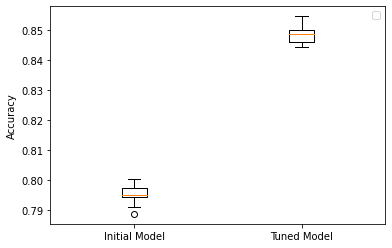

Inital Accuracy
[0.80044223 0.79414041 0.79491432 0.79823107 0.7973466  0.78872305
 0.79491432 0.79535655 0.79712548 0.79104478]
Tuned Accuracy
[0.85174129 0.85450525 0.84886678 0.84776119 0.84820343 0.84411277
 0.84444444 0.84897734 0.84543947 0.85019348]



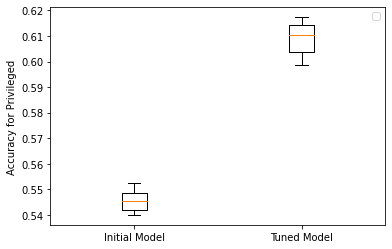

Inital Accuracy Privileged
[0.54322392 0.54078648 0.54614885 0.54127397 0.55053624 0.55248619
 0.539974   0.54549886 0.54517387 0.54956126]
Tuned Accuracy Privileged
[0.60204745 0.61065973 0.61049724 0.60155996 0.61000975 0.61569711
 0.59847254 0.6158596  0.60822229 0.61732207]



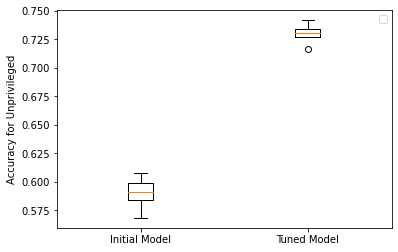

Inital Accuracy Unprivileged
[0.59356624 0.60117606 0.5807679  0.60705638 0.59045313 0.59079903
 0.56831546 0.58353511 0.60774818 0.58526461]
Tuned Accuracy Unprivileged
[0.72708405 0.73400208 0.72673815 0.74022829 0.72742996 0.73400208
 0.71636112 0.72881356 0.73192667 0.7416119 ]



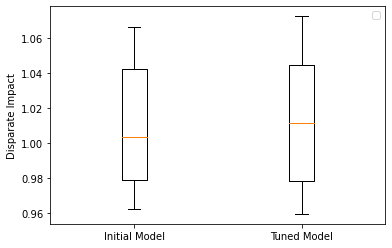

Inital Disparate Impact
[0.97754612 0.97575637 1.04493561 0.96236513 1.04887166 1.03517132
 1.06617425 1.01257374 0.98239465 0.99392687]
Tuned Disparate Impact
[0.95940291 1.07248997 1.04686079 0.9957526  1.04103094 1.02133406
 1.04610129 1.00183308 0.97207304 0.96725871]



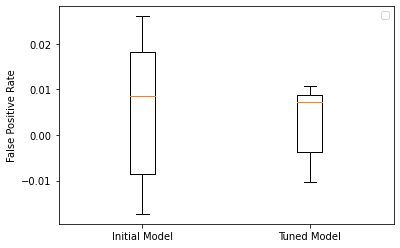

Inital False Positive Rate
[-0.00482167 -0.011648    0.01943692 -0.01729522  0.0188141   0.01652159
  0.02605848  0.00954169 -0.00979146  0.0075896 ]
Tuned False Positive Rate
[-0.00733586  0.01045475  0.01065269 -0.01024009  0.00889854  0.00832691
  0.00602415  0.00866392 -0.00447939 -0.00116561]



In [ ]:

plot_init_v_tuned_box(inital_accuracy, tuned_accuracy, "Accuracy")
print("Inital Accuracy")
print(inital_accuracy)
print("Tuned Accuracy")
print(tuned_accuracy)
print()

plot_init_v_tuned_box(inital_accuracy_priv, tuned_accuracy_priv, "Accuracy for Privileged")
print("Inital Accuracy Privileged")
print(inital_accuracy_priv)
print("Tuned Accuracy Privileged")
print(tuned_accuracy_priv)
print()

plot_init_v_tuned_box(inital_accuracy_unpriv, tuned_accuracy_unpriv, "Accuracy for Unprivileged")
print("Inital Accuracy Unprivileged")
print(inital_accuracy_unpriv)
print("Tuned Accuracy Unprivileged")
print(tuned_accuracy_unpriv)
print()

plot_init_v_tuned_box(inital_disparate, tuned_disparate, "Disparate Impact")
print("Inital Disparate Impact")
print(inital_disparate)
print("Tuned Disparate Impact")
print(tuned_disparate)
print()

plot_init_v_tuned_box(inital_fpr_diff, tuned_fpr_diff, "False Positive Rate")
print("Inital False Positive Rate")
print(inital_fpr_diff)
print("Tuned False Positive Rate")
print(tuned_fpr_diff)
print()


### Hyperparameter tuning of baseline Random Forest
Write functions for hyperparameter tuning a logistic regression model and random forest
model given some X_train, y_train, X_validation, y_validation. Just the functions

**For ten different train/validation/test splits (use different seeds):**

For Random Forest:

*   Minmaxscale the data and separate into features/labels(X/y)
*   Train the baseline model (not hyperparameter tuned) and report 5 metrics on test set
*   Hyperparameter tune and select the best model
*   Train the best model and report 5 metrics on test set (box and whiskers plot)

In [ ]:
def tune_random_forest(x_train, y_train, n_estimator_value, max_depth_value, weights=None, verbose=True):
    '''Tunes random forest models over the hyperparameters penalty type and C
       to maximize the AUC''' 

    # Create empty lists where we will store the results of hyperparameter tuning 
    parameters = []
    models = []
    val_aucs = []
    
    # Loop through the hyperparameters of interest
    for n_estimator in n_estimator_value:
        for max_depth in max_depth_value:
            
            # Train the logistic regression model with the given hyperparameters
            rf = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, random_state=0)
    
            # Fit the model using the training data
            rf = rf.fit(x_train, y_train, sample_weight=weights)
            
            accuracy, auc, accuracy_priv, accuracy_unpriv, disparate, fpr_diff = evaluate(rf, x_train, y_train)

            # Store the results
            parameters.append({'n estimators': n_estimator, 'max depth': max_depth})
            models.append(rf)
            val_aucs.append(auc)
            
            # Print the results
            if verbose:
                print("\nParmeters: \tn estimators={} \tmax depth={}".format(n_estimator, max_depth))
                print("Validtion AUC: {}".format(auc))
            
    
    # Determine the best model -- that is, the one with the AUC
    best_model_index = np.argmax(val_aucs)
    best_model = models[best_model_index]
    
    print("\nBest model parameters: ", parameters[best_model_index])
    print("Best model AUC: ", val_aucs[best_model_index])
    
    # Return best model
    return best_model, parameters, models, val_aucs


In [ ]:
# seed array of 10 numbers 
seed_array= []

inital_accuracy = np.zeros((10))
inital_auc = np.zeros((10))
inital_accuracy_priv = np.zeros((10))
inital_accuracy_unpriv = np.zeros((10))
inital_disparate = np.zeros((10))
inital_fpr_diff = np.zeros((10))

tuned_accuracy = np.zeros((10))
tuned_auc = np.zeros((10))
tuned_accuracy_priv = np.zeros((10))
tuned_accuracy_unpriv = np.zeros((10))
tuned_disparate = np.zeros((10))
tuned_fpr_diff = np.zeros((10))

for i in range(10): 
  seed = np.random.randint(1000)
  seed_array.append(seed)
  train, val, test =  split_train_val_test(dataset_orig, seed)

  # min max scale
  scaler = MinMaxScaler()

  train.features = scaler.fit_transform(train.features)
  test.features = scaler.transform(test.features)
  val.features = scaler.transform(val.features)

  # convert df 
  train_df, _ = train.convert_to_dataframe()
  test_df, _ = test.convert_to_dataframe()
  val_df, _ = val.convert_to_dataframe()

  # separate features
  x_train = train_df.drop("income-per-year", axis=1)
  y_train = train_df["income-per-year"]

  x_test = test_df.drop("income-per-year", axis=1)
  y_test = test_df["income-per-year"]

  x_val = val_df.drop("income-per-year", axis=1)
  y_val = val_df["income-per-year"]

  # inital model for these seeds
  random_forest_reg = RandomForestClassifier(n_estimators=20, random_state=0)
  random_forest_reg = random_forest_reg.fit(x_train, y_train)

  # Get metrics
  inital_accuracy[i], inital_auc[i], inital_accuracy_priv[i], inital_accuracy_unpriv[i], inital_disparate[i], inital_fpr_diff[i]  = evaluate(random_forest_reg, x_test, y_test)

  # tuned model 
  n_estimator_value = [100,150,200,250,300]
  max_depth=[3,4,5,6,7]
  best_rf, parameters, models, val_aucs = tune_random_forest(x_test, y_test, n_estimator_value, max_depth)

  # Get the evalution metrics on the validation set 
  tuned_accuracy[i], tuned_auc[i], tuned_accuracy_priv[i], tuned_accuracy_unpriv[i], tuned_disparate[i], tuned_fpr_diff[i]  = evaluate(best_rf, x_test, y_test) 



Parmeters: 	n estimators=100 	max depth=3
Validtion AUC: 0.5601866416329685

Parmeters: 	n estimators=100 	max depth=4
Validtion AUC: 0.6595173139482282

Parmeters: 	n estimators=100 	max depth=5
Validtion AUC: 0.7052811857189685

Parmeters: 	n estimators=100 	max depth=6
Validtion AUC: 0.7260255340026698

Parmeters: 	n estimators=100 	max depth=7
Validtion AUC: 0.7403814331176404

Parmeters: 	n estimators=150 	max depth=3
Validtion AUC: 0.563715351913658

Parmeters: 	n estimators=150 	max depth=4
Validtion AUC: 0.6613076817102864

Parmeters: 	n estimators=150 	max depth=5
Validtion AUC: 0.702940742554947

Parmeters: 	n estimators=150 	max depth=6
Validtion AUC: 0.7258057215759406

Parmeters: 	n estimators=150 	max depth=7
Validtion AUC: 0.73917723182686

Parmeters: 	n estimators=200 	max depth=3
Validtion AUC: 0.5667885031667769

Parmeters: 	n estimators=200 	max depth=4
Validtion AUC: 0.6502967715185908

Parmeters: 	n estimators=200 	max depth=5
Validtion AUC: 0.7021028953087152

Pa

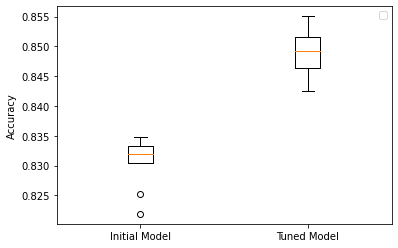

Initial Accuracy
[0.83040354 0.83073521 0.83471531 0.8252073  0.83305694 0.83327805
 0.83150912 0.83327805 0.82189055 0.83250415]
Tuned Accuracy
[0.8525152  0.85174129 0.85008292 0.84278607 0.85505804 0.85107794
 0.84621338 0.8485351  0.84256495 0.84709784]



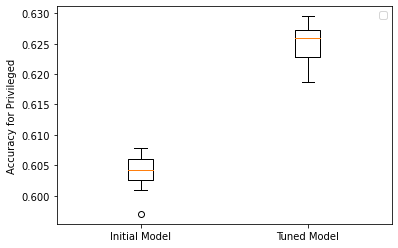

Initial Accuracy Privileged
[0.60448489 0.60285993 0.59701007 0.6039974  0.60643484 0.60497238
 0.60253494 0.6078973  0.60090998 0.60692233]
Tuned Accuracy Privileged
[0.62739682 0.62625934 0.61862203 0.62447189 0.62707182 0.62739682
 0.62154696 0.62950926 0.62219695 0.62544686]



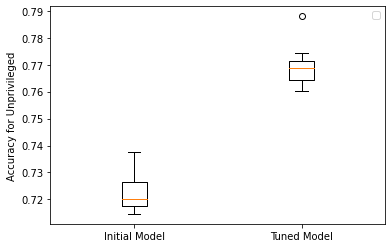

Initial Accuracy Unprivileged
[0.71739882 0.72777586 0.72224144 0.71809063 0.73573158 0.73746109
 0.72189554 0.71774473 0.71532342 0.71463162]
Tuned Accuracy Unprivileged
[0.76755448 0.78796264 0.77135939 0.76686268 0.77101349 0.7744725
 0.76340367 0.76236596 0.76997579 0.76029056]



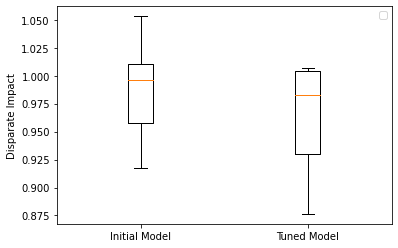

Initial Disparate Impact
[0.96143854 0.95688421 1.01027345 0.99607105 0.942676   0.91775218
 0.99528661 1.01095897 1.01548538 1.05313405]
Tuned Disparate Impact
[0.92485787 0.87638247 0.97767963 0.98862253 0.94583847 0.90011363
 1.00728033 1.0073003  1.00711515 0.99506119]



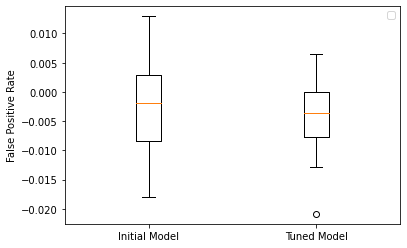

Initial False Positive Rate
[-0.00229269 -0.0099321  -0.00348288  0.0007617  -0.01234576 -0.01791961
 -0.00166645  0.00717766  0.00361817  0.01294945]
Tuned False Positive Rate
[-0.00558337 -0.02088437 -0.00835196 -0.00133878 -0.00573353 -0.01288578
  0.00051433  0.0064141  -0.00162459  0.00279233]



In [ ]:
plot_init_v_tuned_box(inital_accuracy, tuned_accuracy, "Accuracy")
print("Initial Accuracy")
print(inital_accuracy)
print("Tuned Accuracy")
print(tuned_accuracy)
print()

plot_init_v_tuned_box(inital_accuracy_priv, tuned_accuracy_priv, "Accuracy for Privileged")
print("Initial Accuracy Privileged")
print(inital_accuracy_priv)
print("Tuned Accuracy Privileged")
print(tuned_accuracy_priv)
print()

plot_init_v_tuned_box(inital_accuracy_unpriv, tuned_accuracy_unpriv, "Accuracy for Unprivileged")
print("Initial Accuracy Unprivileged")
print(inital_accuracy_unpriv)
print("Tuned Accuracy Unprivileged")
print(tuned_accuracy_unpriv)
print()

plot_init_v_tuned_box(inital_disparate, tuned_disparate, "Disparate Impact")
print("Initial Disparate Impact")
print(inital_disparate)
print("Tuned Disparate Impact")
print(tuned_disparate)
print()

plot_init_v_tuned_box(inital_fpr_diff, tuned_fpr_diff, "False Positive Rate")
print("Initial False Positive Rate")
print(inital_fpr_diff)
print("Tuned False Positive Rate")
print(tuned_fpr_diff)
print()

# Problem 2, Part (c) 
### **Disparate Impact Pre-Processing intervention**

### Logistic Regression

For ten different train/validation/test splits 

For logistic regression:
*   For repair_level in [0.2, 0.4, 0.6, 0.8, 1]:
*   Apply DisparateImpactRemover on train data with given repair_level
*   Fit the best model for this split (found in 2(b)) on the preprocessed data
*   Report 5 metrics on test set (do not transform test set)

In [ ]:
'''
  Run the disparate impact remover on your training and test data at five 
different repair levels (I recommend: 0, 0.25, 0.5, 0.75, 1).
  Take the C value and penalty value from the best logistic regression model 
(i.e. the tuned logistic regression model) you found in 2(b)
  Run the logistic regression on the transformed training and test data. You 
don’t need to tune here. Instead, plug in the above C value and penalty value 
to the logistic regression.
  Calculate the five metrics from the logistic regression model at each 
repair level
'''
seed_array= []

accuracy_di_removed = np.zeros((5, 10))
auc_di_removed = np.zeros((5, 10))
accuracy_priv_di_removed = np.zeros((5, 10))
accuracy_unpriv_di_removed = np.zeros((5, 10))
disparate_di_removed = np.zeros((5, 10))
fpr_diff_di_removed = np.zeros((5, 10))

r = [0.2,0.4,0.6,0.8,1]

for j in range(10): 
  seed = np.random.randint(1000)
  seed_array.append(seed)
  train, val, test =  split_train_val_test(dataset_orig, seed)

  for i in range(5):

    # preprocess the data
    disparate_remover = DisparateImpactRemover(repair_level = r[i], sensitive_attribute = "sex" )
    train_removed = disparate_remover.fit_transform(train)
    test_removed = disparate_remover.fit_transform(test)
    val_removed = disparate_remover.fit_transform(val) 

    # Fit the best model for the split found in 2(b) on the preprocessed data
    # min max scale
    scaler = MinMaxScaler()

    train.features = scaler.fit_transform(train_removed.features)
    test.features = scaler.transform(test_removed.features)
    val.features = scaler.transform(val_removed.features)

    # convert df 
    train_df, _ = train.convert_to_dataframe()
    test_df, _ = test.convert_to_dataframe()
    val_df, _ = val.convert_to_dataframe()

    # separate features
    x_train = train_df.drop("income-per-year", axis=1)
    y_train = train_df["income-per-year"]

    x_test = test_df.drop("income-per-year", axis=1)
    y_test = test_df["income-per-year"]

    x_val = val_df.drop("income-per-year", axis=1)
    y_val = val_df["income-per-year"]

    # use the best model found in the hypertuning C=100, and penalty='11'
    best_log = LogisticRegression(C = 100, penalty='l1', class_weight="balanced", solver="liblinear")
    best_log = best_log.fit(x_train,y_train)

    # Get the evalution metrics on the validation set 
    accuracy_di_removed[i][j], auc_di_removed[i][j], accuracy_priv_di_removed[i][j], accuracy_unpriv_di_removed[i][j], disparate_di_removed[i][j], fpr_diff_di_removed[i][j]  = evaluate(best_log, x_test, y_test) 


In [ ]:
def plot_repair_levels(repair_levels, metric_vals, metric_name, x_label='Repair level'):
  '''Takes a list of repair levels and another list of values of a metric and
  creates a line plot showing how the metric changed for different values of repair level'''

  # Plot the metrics
  plt.plot(repair_levels, metric_vals, color='#0384fc', linewidth=3, label=metric_name)

  # Create labels, etc. 
  plt.xlabel(x_label)
  plt.ylabel(metric_name)
  plt.legend()
  plt.show()

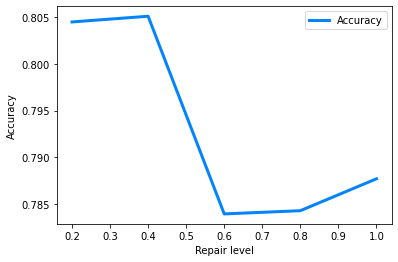

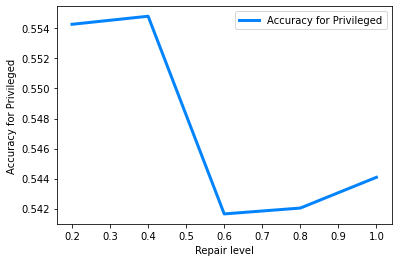

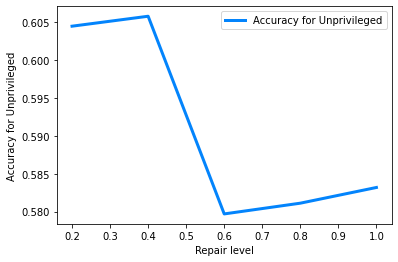

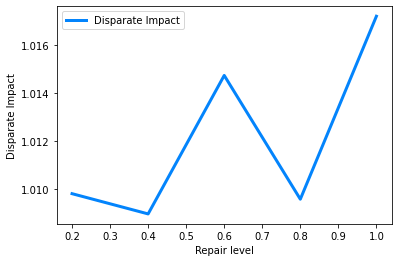

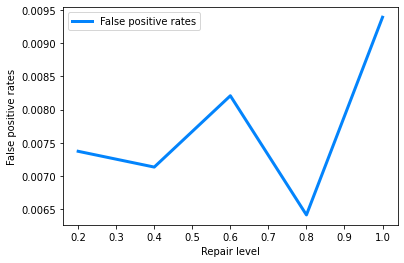

In [ ]:
# find averages for each repair levels for each metric
repair_levels = [0.2,0.4,0.6,0.8,1]

accuracy = np.zeros((5))
accuracy_priv = np.zeros((5))
accuracy_unpriv = np.zeros((5))
disparate = np.zeros((5))
fpr_diff = np.zeros((5))

for i in range(5):
  accuracy[i] = np.average(accuracy_di_removed[i][:])
  accuracy_priv[i] = np.average(accuracy_priv_di_removed[i][:])
  accuracy_unpriv[i] = np.average(accuracy_unpriv_di_removed[i][:])
  disparate[i] = np.average(disparate_di_removed[i][:])
  fpr_diff[i] = np.average(fpr_diff_di_removed[i][:])


# report on 5 metrics
plot_repair_levels(repair_levels,accuracy, "Accuracy", x_label='Repair level')
plot_repair_levels(repair_levels,accuracy_priv, "Accuracy for Privileged", x_label='Repair level')
plot_repair_levels(repair_levels,accuracy_unpriv, "Accuracy for Unprivileged", x_label='Repair level')
plot_repair_levels(repair_levels,disparate, "Disparate Impact", x_label='Repair level')
plot_repair_levels(repair_levels,fpr_diff, "False positive rates", x_label='Repair level')


### Random Forest

For ten different train/validation/test splits 

For logistic regression:
*   For repair_level in [0.2, 0.4, 0.6, 0.8, 1]:
*   Apply DisparateImpactRemover on train data with given repair_level
*   Fit the best model for this split (found in 2(b)) on the preprocessed data
*   Report 5 metrics on test set (do not transform test set)

In [ ]:
# Write code here
# 2D array 
seed_array= []

accuracy_di_removed = np.zeros((5,10))
auc_di_removed = np.zeros((5,10))
accuracy_priv_di_removed = np.zeros((5,10))
accuracy_unpriv_di_removed = np.zeros((5,10))
disparate_di_removed = np.zeros((5,10))
fpr_diff_di_removed = np.zeros((5,10))

r = [0.2,0.4,0.6,0.8,1]

for i in range(10): 
  seed = np.random.randint(1000)
  seed_array.append(seed)
  train, val, test =  split_train_val_test(dataset_orig, seed)

  for j in range(5):

    # preprocess the data
    disparate_remover = DisparateImpactRemover(repair_level = r[j], sensitive_attribute = "sex" )
    train_removed = disparate_remover.fit_transform(train)
    test_removed = disparate_remover.fit_transform(test)
    val_removed = disparate_remover.fit_transform(val) 

    # Fit the best model for the split found in 2(b) on the preprocessed data
    # min max scale
    scaler = MinMaxScaler()

    train.features = scaler.fit_transform(train_removed.features)
    test.features = scaler.transform(test_removed.features)
    val.features = scaler.transform(val_removed.features)

    # convert df 
    train_df, _ = train.convert_to_dataframe()
    test_df, _ = test.convert_to_dataframe()
    val_df, _ = val.convert_to_dataframe()

    # separate features
    x_train = train_df.drop("income-per-year", axis=1)
    y_train = train_df["income-per-year"]

    x_test = test_df.drop("income-per-year", axis=1)
    y_test = test_df["income-per-year"]

    x_val = val_df.drop("income-per-year", axis=1)
    y_val = val_df["income-per-year"]

    # use the best model
    best_rf = RandomForestClassifier(n_estimators=200, max_depth=7)
    best_rf = best_rf.fit(x_train, y_train)
   
    # Get the evalution metrics on the validation set 
    accuracy_di_removed[j][i], auc_di_removed[j][i], accuracy_priv_di_removed[j][i], accuracy_unpriv_di_removed[j][i], disparate_di_removed[j][i], fpr_diff_di_removed[j][i]  = evaluate(best_rf, x_test, y_test) 


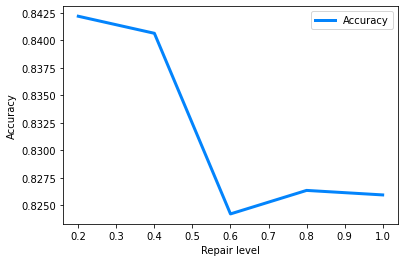

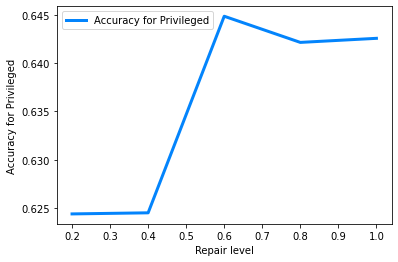

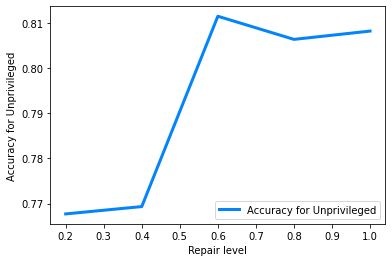

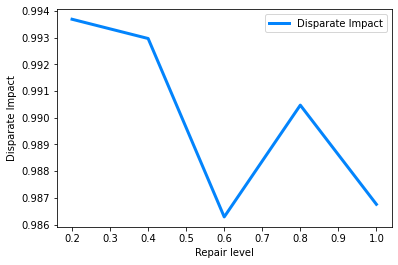

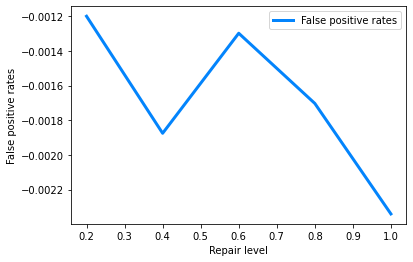

In [ ]:
# find averages for each repair levels for each metric
repair_levels = [0.2,0.4,0.6,0.8,1]
accuracy = np.zeros((5))
accuracy_priv = np.zeros((5))
accuracy_unpriv = np.zeros((5))
disparate = np.zeros((5))
fpr_diff = np.zeros((5))

for i in range(5):
  accuracy[i] = np.average(accuracy_di_removed[i][:])
  accuracy_priv[i] = np.average(accuracy_priv_di_removed[i][:])
  accuracy_unpriv[i] = np.average(accuracy_unpriv_di_removed[i][:])
  disparate[i] = np.average(disparate_di_removed[i][:])
  fpr_diff[i] = np.average(fpr_diff_di_removed[i][:])


# report on 5 metrics
plot_repair_levels(repair_levels,accuracy, "Accuracy")
plot_repair_levels(repair_levels,accuracy_priv, "Accuracy for Privileged")
plot_repair_levels(repair_levels,accuracy_unpriv, "Accuracy for Unprivileged")
plot_repair_levels(repair_levels,disparate, "Disparate Impact")
plot_repair_levels(repair_levels,fpr_diff, "False positive rates")
